First, copy `log.lammps` and `dump.lammpstrj` to the same experiment path as `.pos` and `.in` files were generated (in my case it's `data/03_run_experiments_13-06-24`)

Using the file `log.lammps` we plot curves derived from the experiment. Using the file `dump.lammpstrj` we do clustering on different steps of simulation using Ovito API for Python (in a Destop app it is very routine and time-consuming process) and plot the heatmaps for bacteria types.

In [2]:
from os.path import join
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial import distance

In [3]:
experiment_id = "03_run_experiments_13-06-24"
experiment_type = "bacteria_gt"

### Plot heatmap based on an interaction matrix by Antton

In [4]:
num_bac_genomes = pd.read_csv(f"../../data/01_bacteria_amount/bac_amount_14010_mult_11.75044630883565_thresh_10.tsv", sep='\t')
SHIFT = 1 # 1 -- only bac; 3 -- villi + bac
num_bac_genomes.index = num_bac_genomes.index + SHIFT

rename_dict = dict(zip(num_bac_genomes['genome'], num_bac_genomes.index))

genome_distance_matrix = pd.read_csv("../../data/input_files/genome_functional.distances.txt", sep=" ")
genome_distance_matrix_selected = genome_distance_matrix.loc[list(num_bac_genomes['genome']), list(num_bac_genomes['genome'])]

genome_distance_matrix_renamed = genome_distance_matrix_selected.copy()
genome_distance_matrix_renamed.index = list(map(lambda x: rename_dict[x], genome_distance_matrix_renamed.index))
genome_distance_matrix_renamed.columns = list(map(lambda x: rename_dict[x], genome_distance_matrix_renamed.columns))

/var/folders/ns/t4fb57j54qlg7rb7g3jdcx5c0000gn/T/ipykernel_58190/1106522774.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(genome_distance_matrix_selected, method='average')
/Users/nbykov/miniconda3/envs/gorgona/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/nbykov/miniconda3/envs/gorgona/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


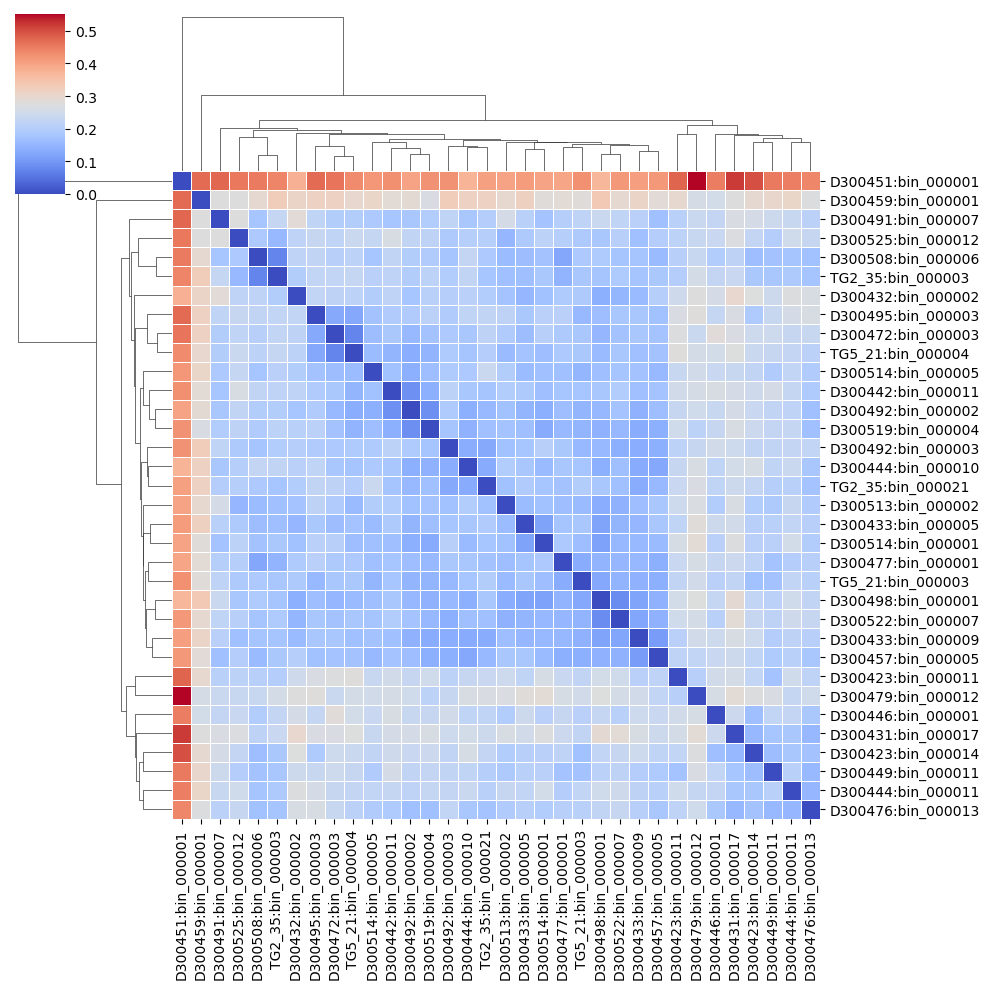

In [5]:
# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(genome_distance_matrix_selected, method='average')

# Define the order of columns based on clustering
order = hierarchy.leaves_list(linkage_matrix)

# Reorder the DataFrame columns based on the clustering order
df_reordered = genome_distance_matrix_selected.iloc[order, order]

# Create a heatmap with a tree hierarchy
sns.clustermap(df_reordered, row_cluster=True, col_cluster=True, cmap='coolwarm', linewidths=0.5, figsize=(10, 10))

plt.savefig(f"../../data/{experiment_id}/{experiment_type}/01_orig_coefs_orig_types.png", dpi=300)
plt.show()


/var/folders/ns/t4fb57j54qlg7rb7g3jdcx5c0000gn/T/ipykernel_58190/4089995267.py:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hierarchy.linkage(genome_distance_matrix_renamed, method='average')
/Users/nbykov/miniconda3/envs/gorgona/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/nbykov/miniconda3/envs/gorgona/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


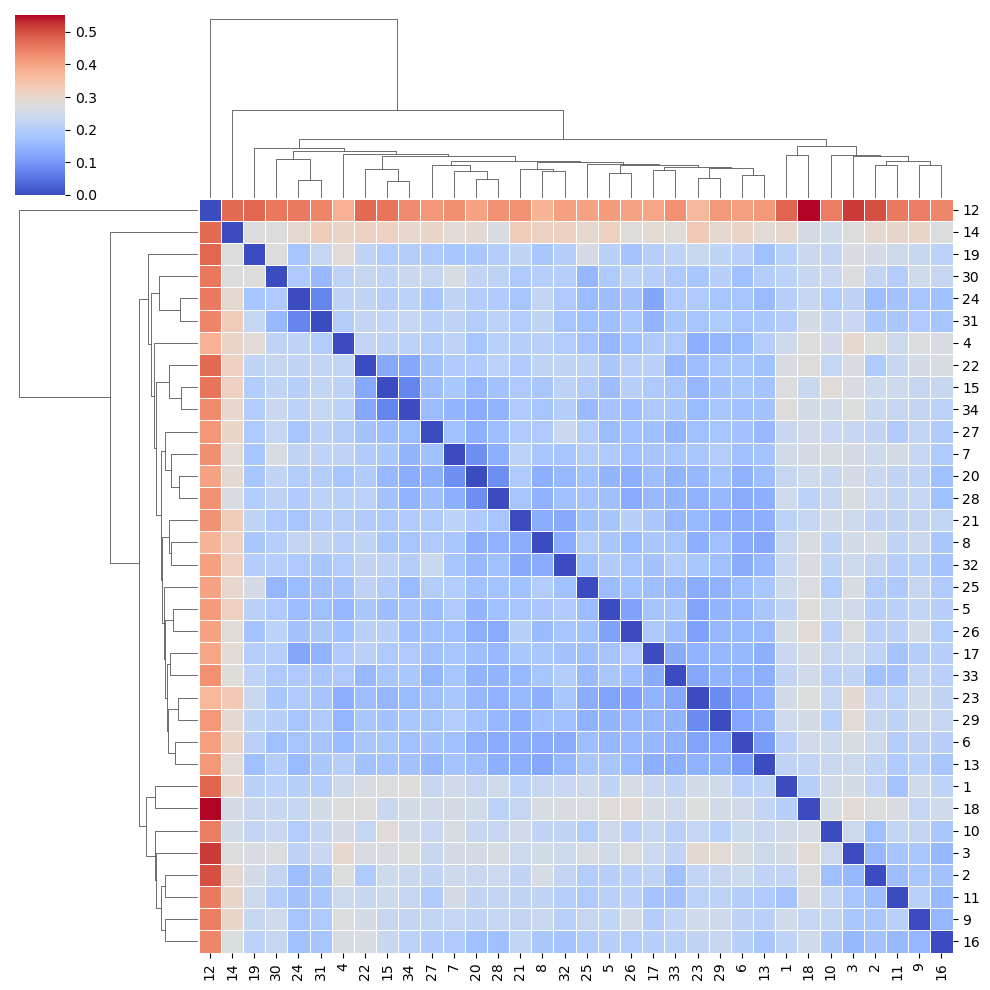

In [6]:
# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(genome_distance_matrix_renamed, method='average')

# Define the order of columns based on clustering
order = hierarchy.leaves_list(linkage_matrix)

# Reorder the DataFrame columns based on the clustering order
df_reordered = genome_distance_matrix_renamed.iloc[order, order]

# Create a heatmap with a tree hierarchy
sns.clustermap(df_reordered, row_cluster=True, col_cluster=True, cmap='coolwarm', linewidths=0.5, figsize=(10, 10))

plt.savefig(f"../../data/{experiment_id}/{experiment_type}/01_orig_coefs_lammps_types.png", dpi=300)
plt.show()


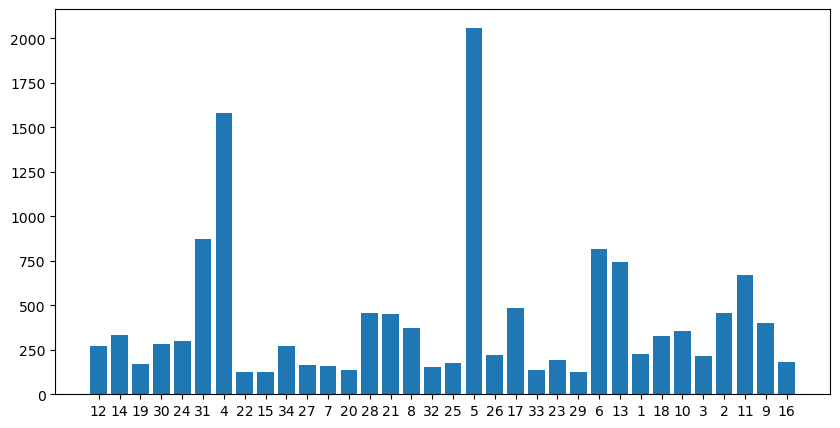

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
plt.bar([str(x) for x in list(num_bac_genomes.loc[df_reordered.index].index)], list(num_bac_genomes.loc[df_reordered.index]['count']))
#plt.ylabel("Number of genomes", size=15)
#plt.xlabel("Bacterial type", size=15)
plt.savefig(f"../../data/{experiment_id}/{experiment_type}/01_bac_freqs_orig_coefs.png", dpi=300)
plt.show()

In [8]:
# check if mean input coefficients for each type correlate with the number of genomes for each type

from scipy.stats import pearsonr, spearmanr, kendalltau

df_reordered_corr = df_reordered.copy()

print("Correlation for all types:")
correlation, pvalue = pearsonr(df_reordered_corr.mean(), num_bac_genomes.loc[df_reordered_corr.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(df_reordered_corr.mean(), num_bac_genomes.loc[df_reordered_corr.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(df_reordered_corr.mean(), num_bac_genomes.loc[df_reordered_corr.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

# They do not correlate. This means that there is not bias in the input data towards the number of genomes for each type

Correlation for all types:
Pearson correlation: -0.10282, 5.62811E-01
Spearman correlation: -0.01085, 9.51440E-01
Kendall correlation: -0.01964, 8.70436E-01


# Cluster analysis

In [9]:
from glob import glob
from itertools import product
from tqdm import tqdm
import numpy as np
from scipy.spatial import distance

In [10]:
cutoff_distance = 0.06

In [11]:
clust_files = sorted(glob(f"../../data/{experiment_id}/{experiment_type}/clust/*.txt"))

In [12]:
insilico_heatmap_inner = pd.DataFrame(0, index=num_bac_genomes.index, columns=num_bac_genomes.index)
# insilico_heatmap_outer = pd.DataFrame(0, index=num_bac_genomes.index, columns=num_bac_genomes.index)

for clust_file in clust_files:
	print(clust_file)
	clust_data = pd.read_csv(clust_file, sep='\t', header=None, names=["atom_id", "atom_type", "coords", "cluster"])
	#atom_types = [int(x) for x in list(set(clust_data['atom_type']))]
	#atom_types_combinations = list(product(atom_types, repeat=2))
	cluster_ids = list(set(clust_data['cluster']))
	no_clust = len(cluster_ids)
	print(f"CLUSTERS: {no_clust}")
	insilico_denominator = 0
	insilico_heatmap_inner_i = pd.DataFrame(0, index=num_bac_genomes.index, columns=num_bac_genomes.index)
	for cluster_id in tqdm(cluster_ids):
		cluster_data_i = clust_data[clust_data['cluster'] == cluster_id].copy()
		# cluster_data_i.reset_index(drop=True, inplace=True)
		if cluster_data_i.shape[0] > 1:
			cluster_data_i['x'], cluster_data_i['y'], cluster_data_i['z'] = zip(*cluster_data_i['coords'].apply(lambda x: x.split()))
			cluster_data_i['x'] = cluster_data_i['x'].astype(float)
			cluster_data_i['y'] = cluster_data_i['y'].astype(float)
			cluster_data_i['z'] = cluster_data_i['z'].astype(float)

			coords = cluster_data_i[['x', 'y', 'z']].values
			distances = distance.cdist(coords, coords, 'euclidean')

			atom_idx = cluster_data_i.index.values
			atom_ids = cluster_data_i['atom_id'].values
			atom_types = cluster_data_i['atom_type'].values
			i, j = np.meshgrid(range(len(atom_idx)), range(len(atom_idx)), indexing='ij')
			distances_df = pd.DataFrame({
				'atom_id_1': atom_idx[i.flatten()],
				'atom_id_2': atom_idx[j.flatten()],
				'atom_type_1': atom_types[i.flatten()],
				'atom_type_2': atom_types[j.flatten()],
				'distance': distances.flatten()
			})
			distances_df_filtered = distances_df.loc[(distances_df['atom_id_1'] < distances_df['atom_id_2']) & (distances_df['distance'] <= cutoff_distance)].copy()
			insilico_denominator += distances_df_filtered.shape[0]
			if distances_df_filtered.shape[0] > 0:
				atom_types_combinations = np.unique(np.concatenate((distances_df_filtered[['atom_type_1', 'atom_type_2']].values, distances_df_filtered[['atom_type_2', 'atom_type_1']].values)), axis=0)
				# atom_types_combinations_new = np.unique(distances_df_filtered[['atom_type_1', 'atom_type_2']].values, axis=0)
				for atom_type_comb in atom_types_combinations:
					atom_type_1, atom_type_2 = atom_type_comb
					# if np.asarray([atom_type_1, atom_type_2]) in atom_types_combinations_new or np.asarray([atom_type_2, atom_type_1]) in atom_types_combinations_new:
					insilico_heatmap_inner_i.loc[atom_type_1, atom_type_2] += distances_df_filtered[((distances_df_filtered['atom_type_1'] == atom_type_1) & (distances_df_filtered['atom_type_2'] == atom_type_2)) | ((distances_df_filtered['atom_type_1'] == atom_type_2) & (distances_df_filtered['atom_type_2'] == atom_type_1))].shape[0]
					# insilico_heatmap_outer.loc[atom_type_1, atom_type_2] += distances_df_filtered.shape[0]
					# insilico_heatmap_outer.loc[atom_type_1, atom_type_2] += distances_df_filtered[(distances_df_filtered['atom_type_1'] == atom_type_1) | (distances_df_filtered['atom_type_2'] == atom_type_2) | (distances_df_filtered['atom_type_1'] == atom_type_2) | (distances_df_filtered['atom_type_2'] == atom_type_1)].shape[0]
					#if np.asarray([atom_type_2, atom_type_1]) not in atom_types_combinations:
					#	insilico_heatmap_inner.loc[atom_type_2, atom_type_1] += distances_df_filtered[((distances_df_filtered['atom_type_1'] == atom_type_1) & (distances_df_filtered['atom_type_2'] == atom_type_2)) | ((distances_df_filtered['atom_type_1'] == atom_type_2) & (distances_df_filtered['atom_type_2'] == atom_type_1))].shape[0]
					#	insilico_heatmap_outer.loc[atom_type_2, atom_type_1] += distances_df_filtered[(distances_df_filtered['atom_type_1'] == atom_type_1) | (distances_df_filtered['atom_type_2'] == atom_type_2) | (distances_df_filtered['atom_type_1'] == atom_type_2) | (distances_df_filtered['atom_type_2'] == atom_type_1)].shape[0]
	insilico_heatmap_inner_i /= insilico_denominator
	insilico_heatmap_inner += insilico_heatmap_inner_i

insilico_heatmap_inner /= len(clust_files)
#insilico_heatmap_outer = insilico_heatmap_outer / len(clust_files)


../../data/03_run_experiments_13-06-24/bacteria_gt/clust/clust_2.50M.txt
CLUSTERS: 158


100%|██████████| 158/158 [00:07<00:00, 21.33it/s]


../../data/03_run_experiments_13-06-24/bacteria_gt/clust/clust_2.55M.txt
CLUSTERS: 155


100%|██████████| 155/155 [00:07<00:00, 20.12it/s]


../../data/03_run_experiments_13-06-24/bacteria_gt/clust/clust_2.60M.txt
CLUSTERS: 153


100%|██████████| 153/153 [00:07<00:00, 20.23it/s]


../../data/03_run_experiments_13-06-24/bacteria_gt/clust/clust_2.65M.txt
CLUSTERS: 155


100%|██████████| 155/155 [00:07<00:00, 20.11it/s]


../../data/03_run_experiments_13-06-24/bacteria_gt/clust/clust_2.70M.txt
CLUSTERS: 154


100%|██████████| 154/154 [00:06<00:00, 22.02it/s]


../../data/03_run_experiments_13-06-24/bacteria_gt/clust/clust_2.75M.txt
CLUSTERS: 152


100%|██████████| 152/152 [00:07<00:00, 19.75it/s]


../../data/03_run_experiments_13-06-24/bacteria_gt/clust/clust_2.80M.txt
CLUSTERS: 152


100%|██████████| 152/152 [00:08<00:00, 18.48it/s]


../../data/03_run_experiments_13-06-24/bacteria_gt/clust/clust_2.85M.txt
CLUSTERS: 150


100%|██████████| 150/150 [00:07<00:00, 19.07it/s]


../../data/03_run_experiments_13-06-24/bacteria_gt/clust/clust_2.90M.txt
CLUSTERS: 153


100%|██████████| 153/153 [00:08<00:00, 17.87it/s]


../../data/03_run_experiments_13-06-24/bacteria_gt/clust/clust_2.95M.txt
CLUSTERS: 150


100%|██████████| 150/150 [00:07<00:00, 19.44it/s]


../../data/03_run_experiments_13-06-24/bacteria_gt/clust/clust_3.00M.txt
CLUSTERS: 146


100%|██████████| 146/146 [00:07<00:00, 19.08it/s]


In [40]:
insilico_heatmap_inner

,1,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,33,34
1,0.004031,0.000863,0.000418,0.001552,0.001817,0.001058,0.000207,0.000343,0.000560,0.000559,...,0.000182,0.000396,0.000214,0.000661,0.000161,0.000431,0.001285,0.000181,0.000178,0.000419
2,0.000863,0.012318,0.001647,0.001996,0.004257,0.001205,0.000590,0.000945,0.001874,0.001907,...,0.000540,0.000832,0.000760,0.000504,0.000363,0.000919,0.002454,0.000455,0.000368,0.000516
3,0.000418,0.001647,0.003319,0.001146,0.001542,0.000669,0.000363,0.000437,0.000919,0.000587,...,0.000241,0.000225,0.000319,0.000560,0.000154,0.000138,0.001066,0.000162,0.000253,0.000503
4,0.001552,0.001996,0.001146,0.080871,0.011882,0.006717,0.001262,0.002684,0.001957,0.001646,...,0.001485,0.001768,0.001327,0.003003,0.001495,0.002067,0.003977,0.000707,0.001269,0.002138
5,0.001817,0.004257,0.001542,0.011882,0.116108,0.007288,0.002174,0.002967,0.002477,0.002571,...,0.002818,0.004168,0.002763,0.003824,0.001415,0.002393,0.007205,0.000999,0.001369,0.003258
6,0.001058,0.001205,0.000669,0.006717,0.007288,0.032268,0.001064,0.002909,0.002084,0.000757,...,0.001113,0.001163,0.000981,0.003287,0.001382,0.001574,0.003040,0.001261,0.001232,0.001376
7,0.000207,0.000590,0.000363,0.001262,0.002174,0.001064,0.001810,0.000701,0.000426,0.000270,...,0.000177,0.000138,0.000348,0.000843,0.000171,0.000296,0.000329,0.000246,0.000462,0.000681
8,0.000343,0.000945,0.000437,0.002684,0.002967,0.002909,0.000701,0.008801,0.000537,0.001120,...,0.000557,0.000844,0.000635,0.002411,0.000441,0.000602,0.001145,0.001000,0.000518,0.000422
9,0.000560,0.001874,0.000919,0.001957,0.002477,0.002084,0.000426,0.000537,0.011870,0.000945,...,0.000165,0.000539,0.000161,0.000541,0.000253,0.000732,0.001498,0.000409,0.000309,0.000592
10,0.000559,0.001907,0.000587,0.001646,0.002571,0.000757,0.000270,0.001120,0.000945,0.008943,...,0.000507,0.000518,0.000574,0.000847,0.000405,0.000630,0.001685,0.000361,0.000363,0.000500


In [13]:
# insilico_heatmap_result = insilico_heatmap_inner / insilico_heatmap_outer

In [14]:
# check if sum of all pairwise combinations is equal to 1
tol = 1e-5
assert abs((insilico_heatmap_inner.sum().sum() - insilico_heatmap_inner.values.trace()) / 2 + insilico_heatmap_inner.values.trace() - 1) < tol


In [15]:
# Normalize the heatmap by the abundance of bacterial types

# Create a NumPy array from the original list
outer_sum = np.add.outer(list(num_bac_genomes['count']), list(num_bac_genomes['count'])) / (num_bac_genomes['count'].sum() * len(num_bac_genomes['count']))
heatmap_denominator = pd.DataFrame(outer_sum, index=num_bac_genomes.index, columns=num_bac_genomes.index)

# outer_product = np.outer(num_bac_genomes['count'], num_bac_genomes['count']) / (num_bac_genomes['count'].sum() ** 2)
# outer_product = np.outer(num_bac_genomes['count'], num_bac_genomes['count'])
# heatmap_denominator = pd.DataFrame(outer_product, index=num_bac_genomes.index, columns=num_bac_genomes.index)

## in case of add outer:
diag_indices = np.diag_indices(heatmap_denominator.shape[0])
# Divide the diagonal elements by 2
heatmap_denominator.values[diag_indices] /= 2

In [16]:
# check if sum of all pairwise combinations is equal to 1
tol = 1e-5
assert abs((heatmap_denominator.sum().sum() - heatmap_denominator.values.trace()) / 2 + heatmap_denominator.values.trace() - 1)	< tol


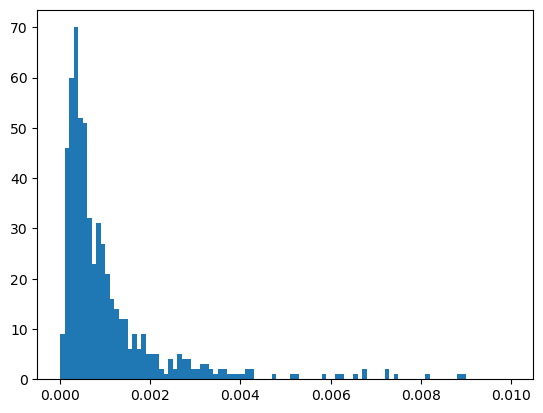

In [17]:
plt.hist(insilico_heatmap_inner.values[np.triu_indices(insilico_heatmap_inner.shape[0], k=0)].flatten(), bins=100, range=(0,0.01))
plt.show()


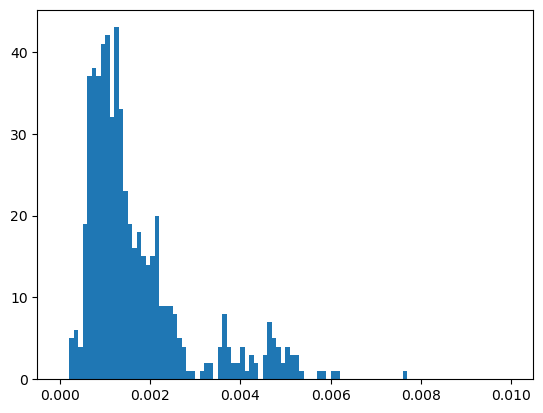

In [18]:
plt.hist(heatmap_denominator.values[np.triu_indices(heatmap_denominator.shape[0], k=0)].flatten(), bins=100, range=(0, 0.01))
plt.show()


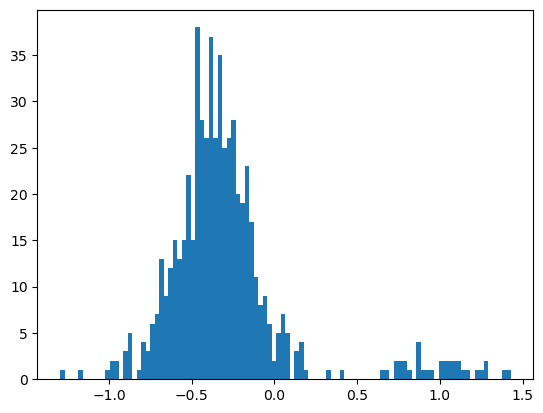

In [19]:
insilico_heatmap_result_final = np.log10(insilico_heatmap_inner / heatmap_denominator)
plt.hist(insilico_heatmap_result_final.values[np.triu_indices(insilico_heatmap_result_final.shape[0], k=0)].flatten(), bins=100)
plt.show()

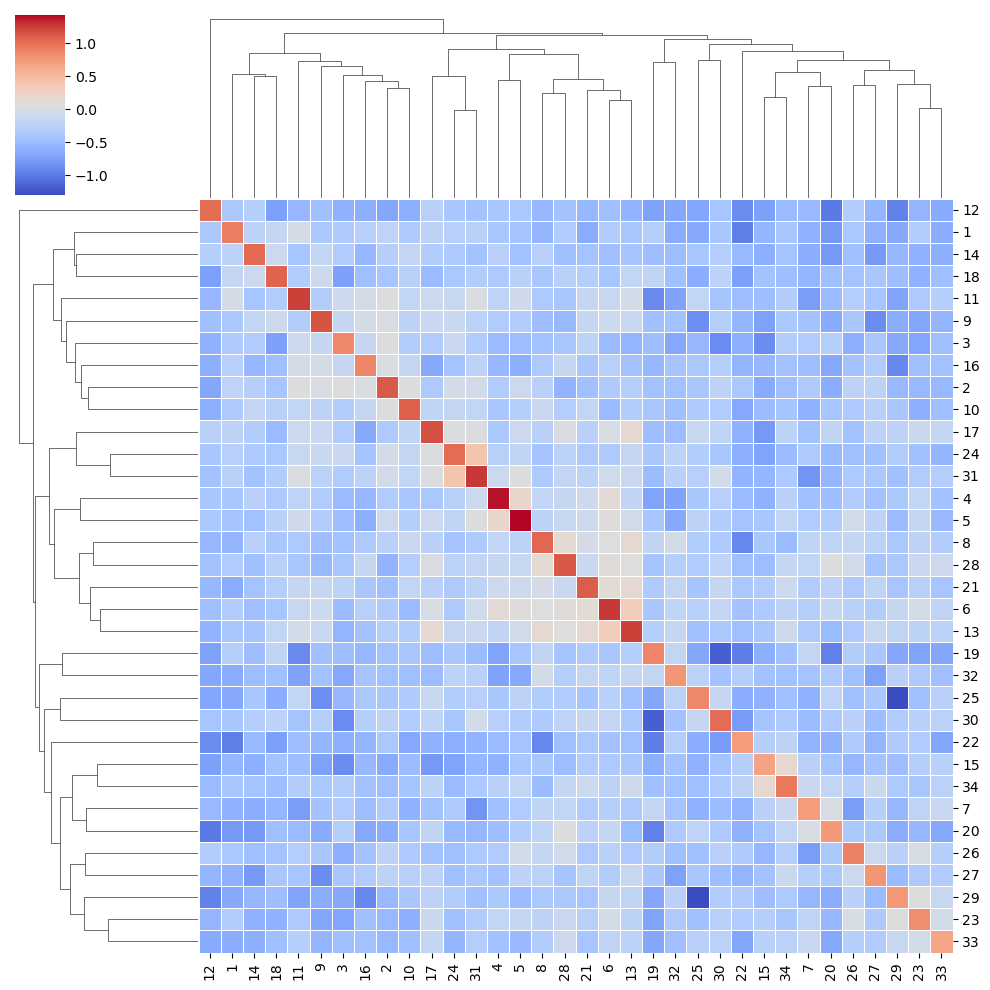

In [20]:
# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(insilico_heatmap_result_final, method='average')

# Define the order of columns based on clustering
order = hierarchy.leaves_list(linkage_matrix)

# Reorder the DataFrame columns based on the clustering order
df_reordered_observed = insilico_heatmap_result_final.iloc[order, order]

# Create a heatmap with a tree hierarchy
clustermap_observed = sns.clustermap(df_reordered_observed, row_cluster=True, col_cluster=True, cmap='coolwarm', linewidths=0.5, figsize=(10, 10))

plt.savefig(f"../../data/{experiment_id}/{experiment_type}/ours_func_sim_34_bac_LAM_TYPES.png", dpi=300)
plt.show()

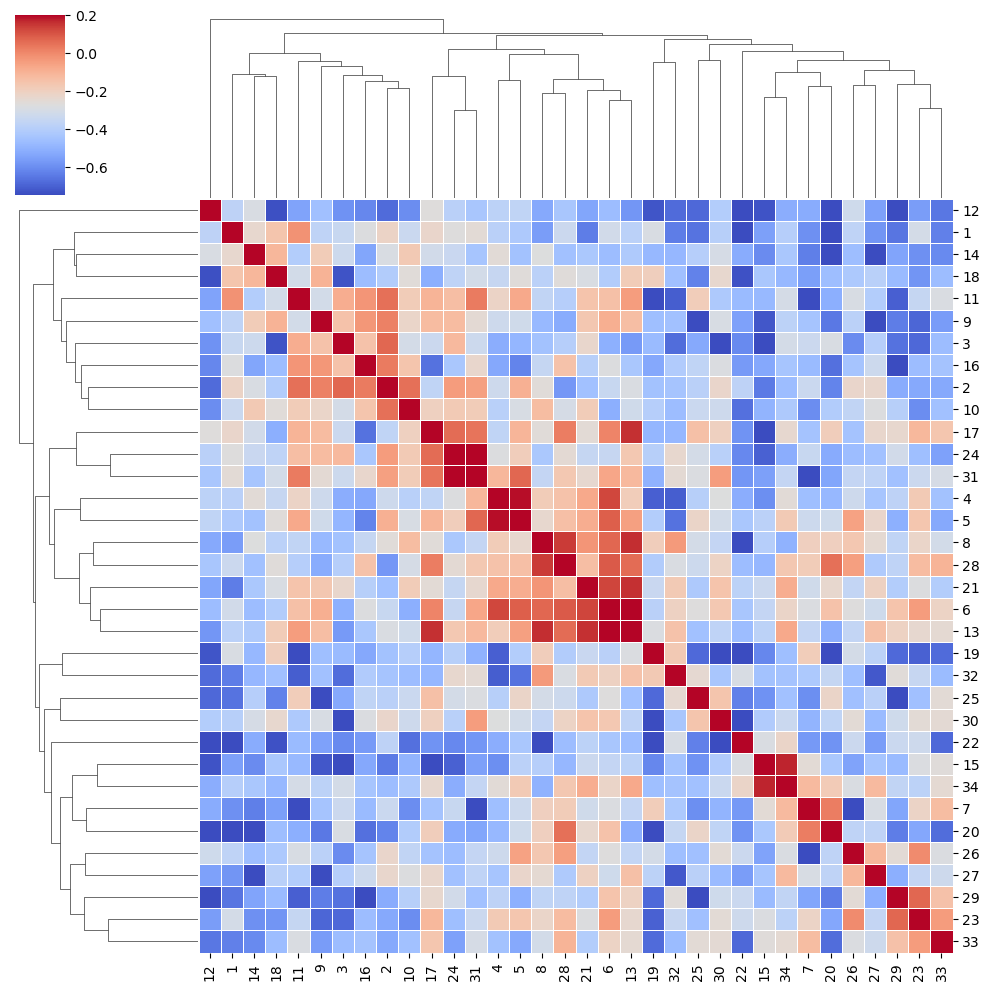

In [21]:
# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(insilico_heatmap_result_final, method='average')

# Define the order of columns based on clustering
order = hierarchy.leaves_list(linkage_matrix)

# Reorder the DataFrame columns based on the clustering order
df_reordered_observed = insilico_heatmap_result_final.iloc[order, order]

# Create a heatmap with a tree hierarchy
clustermap_observed = sns.clustermap(df_reordered_observed, row_cluster=True, col_cluster=True, cmap='coolwarm', linewidths=0.5, figsize=(10, 10), vmax=0.2, vmin=-0.75)

plt.savefig(f"../../data/{experiment_id}/{experiment_type}/ours_func_sim_34_bac_LAM_TYPES.png", dpi=300)
plt.show()

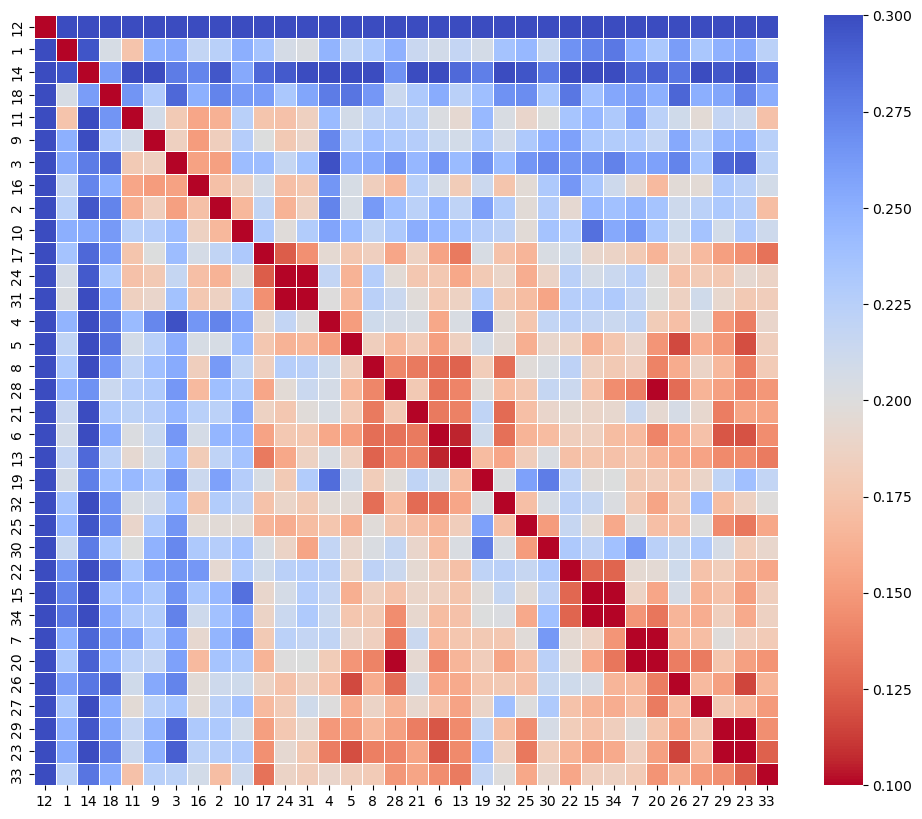

In [22]:
final_labels = clustermap_observed.ax_heatmap.yaxis.get_majorticklabels()
final_labels = [int(x.get_text()) for x in final_labels]

df_reordered_expected = genome_distance_matrix_renamed.reindex(columns=final_labels, index=final_labels)

# df_reordered_expected = 1 / df_reordered_expected

# Create a heatmap with a tree hierarchy

fig, ax = plt.subplots(figsize=(12,10)) 
# sns.heatmap(df_reordered_expected, cmap='coolwarm', linewidths=0.5, ax=ax, vmax=10, vmin=1.8)
clustermap_expected = sns.heatmap(df_reordered_expected, cmap='coolwarm_r', linewidths=0.5, ax=ax, vmax=0.3, vmin=0.1)

plt.savefig(f"../../data/{experiment_id}/{experiment_type}/antton_lammps_type_reordered.png", dpi=300)
plt.show()

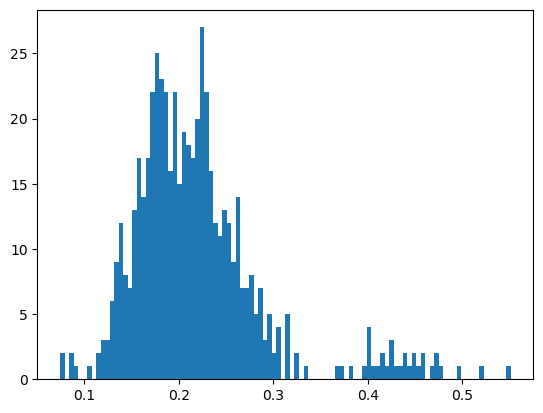

In [23]:

plt.hist(df_reordered_expected.values[np.triu_indices(df_reordered_expected.shape[0], k=1)].flatten(), bins=100)
plt.show()

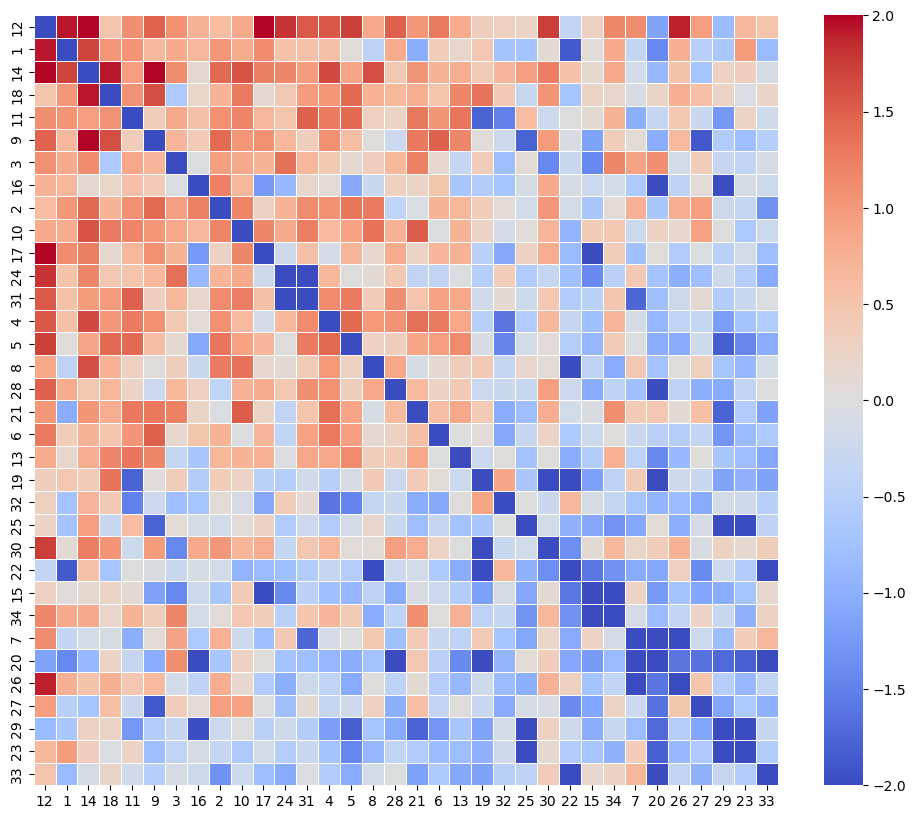

In [24]:
import numpy as np

df_reordered_expected_inverted = 1 / df_reordered_expected
diag_indices_new = np.diag_indices(df_reordered_expected_inverted.shape[0])
df_reordered_expected_inverted.values[diag_indices_new] = 1000000


# Extract the upper triangle of the matrix
upper_triangle_observed = df_reordered_observed.where(np.triu(np.ones(df_reordered_observed.shape), k=1).astype(bool)).values.flatten()
upper_triangle_expected = df_reordered_expected_inverted.where(np.triu(np.ones(df_reordered_expected_inverted.shape), k=1).astype(bool)).values.flatten()
upper_triangle_observed = upper_triangle_observed[~np.isnan(upper_triangle_observed)]
upper_triangle_expected = upper_triangle_expected[~np.isnan(upper_triangle_expected)]

# Calculate the mean and standard deviation of the upper triangle
mean_observed = upper_triangle_observed.mean()
std_observed = upper_triangle_observed.std()

mean_expected = upper_triangle_expected.mean()
std_expected = upper_triangle_expected.std()

# Subtract the mean and divide by the standard deviation for all elements in the matrix
df_reordered_observed_normalized = (df_reordered_observed - mean_observed) / std_observed
df_reordered_expected_normalized = (df_reordered_expected_inverted - mean_expected) / std_expected


fig, ax = plt.subplots(figsize=(12,10)) 
# sns.heatmap(df_reordered_expected, cmap='coolwarm', linewidths=0.5, ax=ax, vmax=10, vmin=1.8)
clustermap_diff = sns.heatmap(df_reordered_observed_normalized - df_reordered_expected_normalized, cmap='coolwarm', linewidths=0.5, ax=ax, vmin=-2, vmax=2)

plt.savefig(f"../../data/{experiment_id}/{experiment_type}/diff_obs_exp.png", dpi=300)
plt.show()

<BarContainer object of 34 artists>

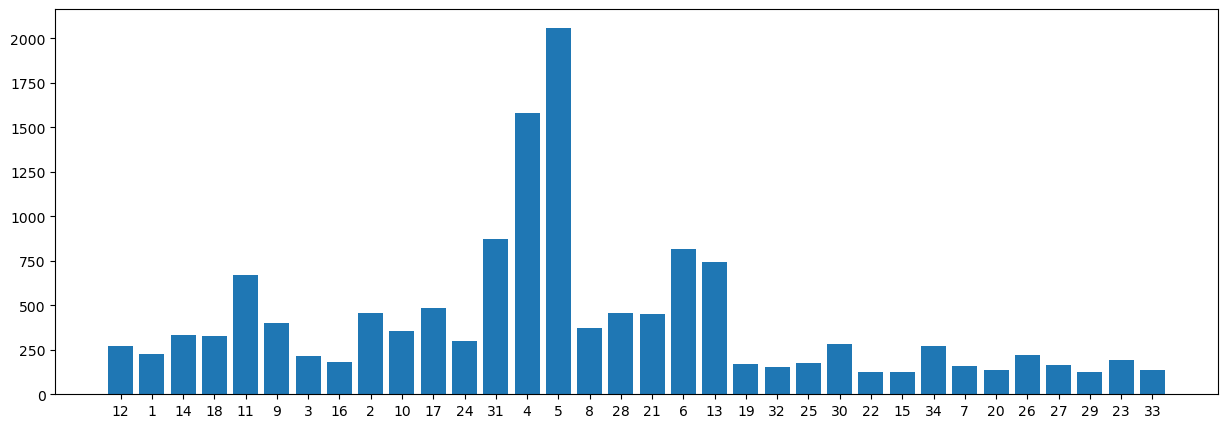

In [25]:
fig, ax = plt.subplots(figsize=(15,5))
plt.bar([str(x) for x in list(num_bac_genomes.loc[df_reordered_observed_normalized.index].index)], list(num_bac_genomes.loc[df_reordered_observed_normalized.index]['count']))

In [26]:
# check if mean observed signal for each type correlates with the number of bacteria of each type

from scipy.stats import pearsonr, spearmanr, kendalltau

df_reordered_observed_corr = df_reordered_observed.copy()

print("Correlation for all types:")
correlation, pvalue = pearsonr(df_reordered_observed_corr.mean(), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(df_reordered_observed_corr.mean(), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(df_reordered_observed_corr.mean(), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

print("\nCorrelation for diagonal only")
correlation, pvalue = pearsonr(np.diag(df_reordered_observed_corr), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(np.diag(df_reordered_observed_corr), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(np.diag(df_reordered_observed_corr), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

print("\nCorrelation for non-diagonal only")
np.fill_diagonal(df_reordered_observed_corr.values, np.nan)
correlation, pvalue = pearsonr(df_reordered_observed_corr.mean(), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(df_reordered_observed_corr.mean(), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(df_reordered_observed_corr.mean(), num_bac_genomes.loc[df_reordered_observed_corr.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))


Correlation for all types:
Pearson correlation: 0.56650, 4.78185E-04
Spearman correlation: 0.83191, 1.08549E-09
Kendall correlation: 0.64464, 8.66033E-08

Correlation for diagonal only
Pearson correlation: 0.82565, 1.85719E-09
Spearman correlation: 0.98334, 2.86105E-25
Kendall correlation: 0.90536, 5.57717E-14

Correlation for non-diagonal only
Pearson correlation: 0.53846, 1.01944E-03
Spearman correlation: 0.80623, 8.66311E-09
Kendall correlation: 0.60893, 4.27589E-07


In [27]:
# check if mean observed signal for each type correlates with the number of bacteria of each type

from scipy.stats import pearsonr, spearmanr, kendalltau

df_reordered_observed_corr_diff = (df_reordered_observed_normalized - df_reordered_expected_normalized).copy()

print("Correlation for all types:")
correlation, pvalue = pearsonr(df_reordered_observed_corr_diff.mean(), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(df_reordered_observed_corr_diff.mean(), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(df_reordered_observed_corr_diff.mean(), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

print("\nCorrelation for diagonal only")
correlation, pvalue = pearsonr(np.diag(df_reordered_observed_corr_diff), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(np.diag(df_reordered_observed_corr_diff), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(np.diag(df_reordered_observed_corr_diff), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

print("\nCorrelation for non-diagonal only")
np.fill_diagonal(df_reordered_observed_corr_diff.values, np.nan)
correlation, pvalue = pearsonr(df_reordered_observed_corr_diff.mean(), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(df_reordered_observed_corr_diff.mean(), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(df_reordered_observed_corr_diff.mean(), num_bac_genomes.loc[df_reordered_observed_corr_diff.index]['count'])
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))


Correlation for all types:
Pearson correlation: 0.39020, 2.25220E-02
Spearman correlation: 0.72616, 1.16773E-06
Kendall correlation: 0.53036, 1.06357E-05

Correlation for diagonal only
Pearson correlation: 0.82565, 1.85719E-09
Spearman correlation: 0.98334, 2.86105E-25
Kendall correlation: 0.90536, 5.57717E-14

Correlation for non-diagonal only
Pearson correlation: 0.35823, 3.75009E-02
Spearman correlation: 0.71516, 2.00722E-06
Kendall correlation: 0.51607, 1.82570E-05


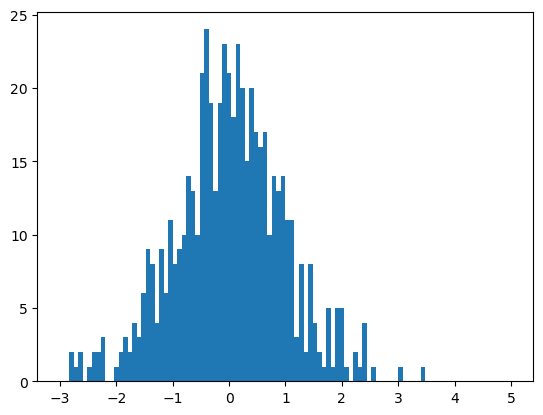

In [28]:

plt.hist(((upper_triangle_observed - mean_observed) / std_observed).flatten(), bins=100, range=(-3,5))
plt.show()

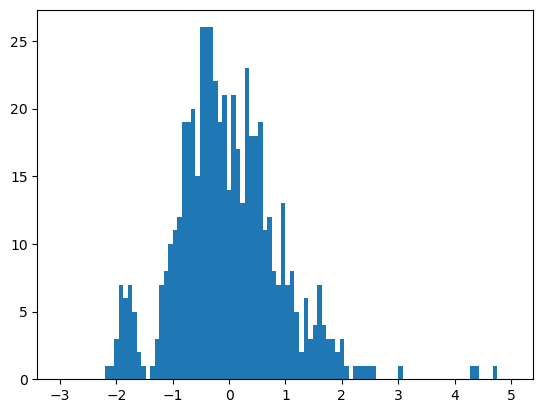

In [29]:
plt.hist(((upper_triangle_expected - mean_expected) / std_expected).flatten(), bins=100, range=(-3,5))
plt.show()

In [30]:
# check correlation between ovserved and expected (not inverted and not normalized)

from scipy.stats import pearsonr, spearmanr, kendalltau

# Flatten the upper triangular part of the matrices
upper_tri_expected = df_reordered_expected.values[np.triu_indices(df_reordered_expected.shape[0], k=1)]
upper_tri_observed = df_reordered_observed.values[np.triu_indices(df_reordered_observed.shape[0], k=1)]


correlation, pvalue = pearsonr(upper_tri_expected, upper_tri_observed)
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(upper_tri_expected, upper_tri_observed)
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(upper_tri_expected, upper_tri_observed)
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

# Correlation is negative because we use original expected matrix from Antton,
# where lower coefficients mean higher similarity

Pearson correlation: -0.46978, 3.85516E-32
Spearman correlation: -0.52850, 1.10273E-41
Kendall correlation: -0.36872, 5.64092E-39


In [31]:
# check correlation between ovserved and expected (inverted and normalized)

from scipy.stats import pearsonr, spearmanr, kendalltau

# Flatten the upper triangular part of the matrices
upper_tri_expected = df_reordered_expected_normalized.values[np.triu_indices(df_reordered_expected_normalized.shape[0], k=1)]
upper_tri_observed = df_reordered_observed_normalized.values[np.triu_indices(df_reordered_observed_normalized.shape[0], k=1)]


correlation, pvalue = pearsonr(upper_tri_expected, upper_tri_observed)
print("Pearson correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = spearmanr(upper_tri_expected, upper_tri_observed)
print("Spearman correlation: {:.5f}, {:.5E}".format(correlation, pvalue))
correlation, pvalue = kendalltau(upper_tri_expected, upper_tri_observed)
print("Kendall correlation: {:.5f}, {:.5E}".format(correlation, pvalue))

# Correlation is positive because we use inverted expected matrix from Antton

Pearson correlation: 0.55055, 8.92351E-46
Spearman correlation: 0.52850, 1.10273E-41
Kendall correlation: 0.36872, 5.64092E-39


In [32]:
header = ["Step", "Temp", "PotEng", "KinEng", "TotEng", "Press", "c_Tbacteria", "c_KEbacteria", "c_PEbacteria",  "CPU"]
pattern = re.compile(r'^\s+\d+')

In [33]:
data_file = f"../../data/{experiment_id}/{experiment_type}/log.lammps"
with open(data_file, 'r') as f:
    lammps_logs = f.readlines()

In [34]:
lammps_logs_selected = [x for x in lammps_logs if pattern.match(x)]

In [35]:
def get_step_rows(x):
    adj_row = [y for y in x.strip("\n").split(' ') if y != '']
    try:
        if int(adj_row[0]) % 1000 == 0 and '.' in adj_row[2] and '.' not in adj_row[0] and len(adj_row) == 10:
            return adj_row
    except:
        pass

In [36]:
lammps_logs_selected = [get_step_rows(x) for x in lammps_logs_selected if get_step_rows(x)]

In [37]:
df_lammps_logs_selected = pd.DataFrame(lammps_logs_selected, columns=header)
df_lammps_logs_selected['Step'] = df_lammps_logs_selected['Step'].astype(int)
df_lammps_logs_selected['Temp'] = df_lammps_logs_selected['Temp'].astype(float)
df_lammps_logs_selected['PotEng'] = df_lammps_logs_selected['PotEng'].astype(float)
df_lammps_logs_selected['KinEng'] = df_lammps_logs_selected['KinEng'].astype(float)
df_lammps_logs_selected['TotEng'] = df_lammps_logs_selected['TotEng'].astype(float)
df_lammps_logs_selected['Press'] = df_lammps_logs_selected['Press'].astype(float)
df_lammps_logs_selected['c_Tbacteria'] = df_lammps_logs_selected['c_Tbacteria'].astype(float)
#df_lammps_logs_selected['c_Tvilli'] = df_lammps_logs_selected['c_Tvilli'].astype(float)
df_lammps_logs_selected['c_KEbacteria'] = df_lammps_logs_selected['c_KEbacteria'].astype(float)
#df_lammps_logs_selected['c_KEvilli'] = df_lammps_logs_selected['c_KEvilli'].astype(float)
df_lammps_logs_selected['c_PEbacteria'] = df_lammps_logs_selected['c_PEbacteria'].astype(float)
#df_lammps_logs_selected['c_PEvilli'] = df_lammps_logs_selected['c_PEvilli'].astype(float)
df_lammps_logs_selected['CPU'] = df_lammps_logs_selected['CPU'].astype(float)

df_lammps_logs_selected.index = list(df_lammps_logs_selected['Step'])

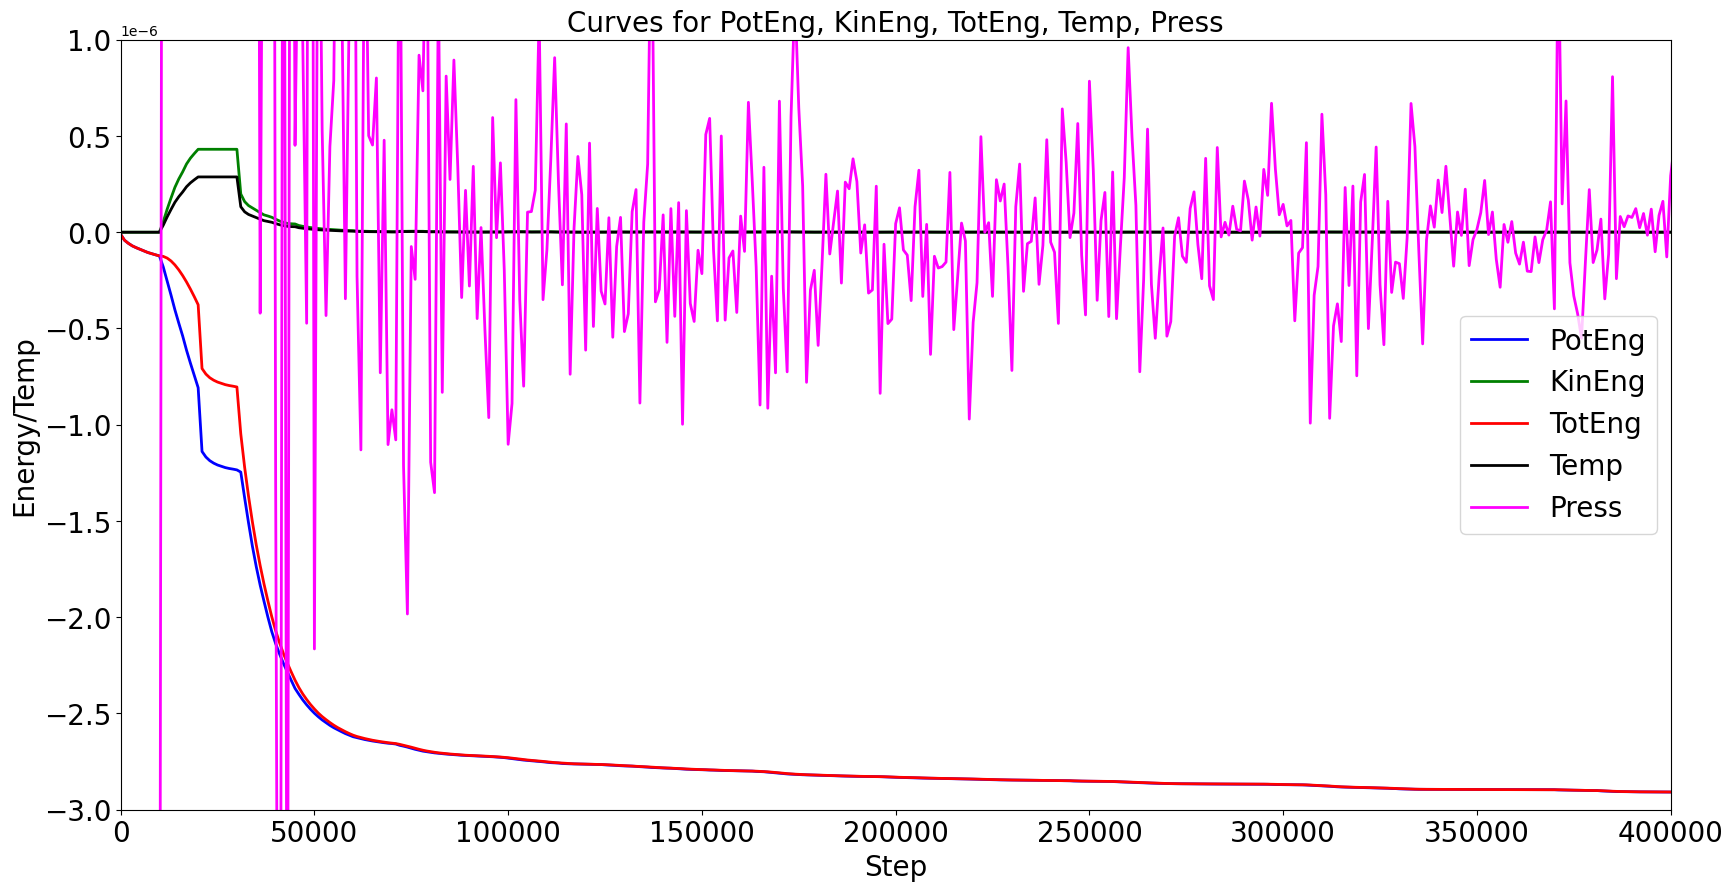

In [38]:
plt.figure(figsize=(20, 10))
# Plot curves for the specified columns
plt.plot(df_lammps_logs_selected['PotEng'], label='PotEng', color='blue', linewidth=2)
plt.plot(df_lammps_logs_selected['KinEng'], label='KinEng', color='green', linewidth=2)
plt.plot(df_lammps_logs_selected['TotEng'], label='TotEng', color='red', linewidth=2)
plt.plot(df_lammps_logs_selected['Temp'], label='Temp', color='black', linewidth=2)
plt.plot(df_lammps_logs_selected['Press'], label='Press', color='magenta', linewidth=2)

# Add labels and legend
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Step', fontsize=20)
plt.ylabel('Energy/Temp', fontsize=20)
plt.title('Curves for PotEng, KinEng, TotEng, Temp, Press', fontsize=20)
plt.ylim((-3e-6, 1e-6))
plt.xlim((-0.2, 0.04 * 10e6))
plt.legend(fontsize=20)
plt.savefig(f"../../data/{experiment_id}/{experiment_type}/tot_measurements.png", dpi=300)
# Show the plot
plt.show()

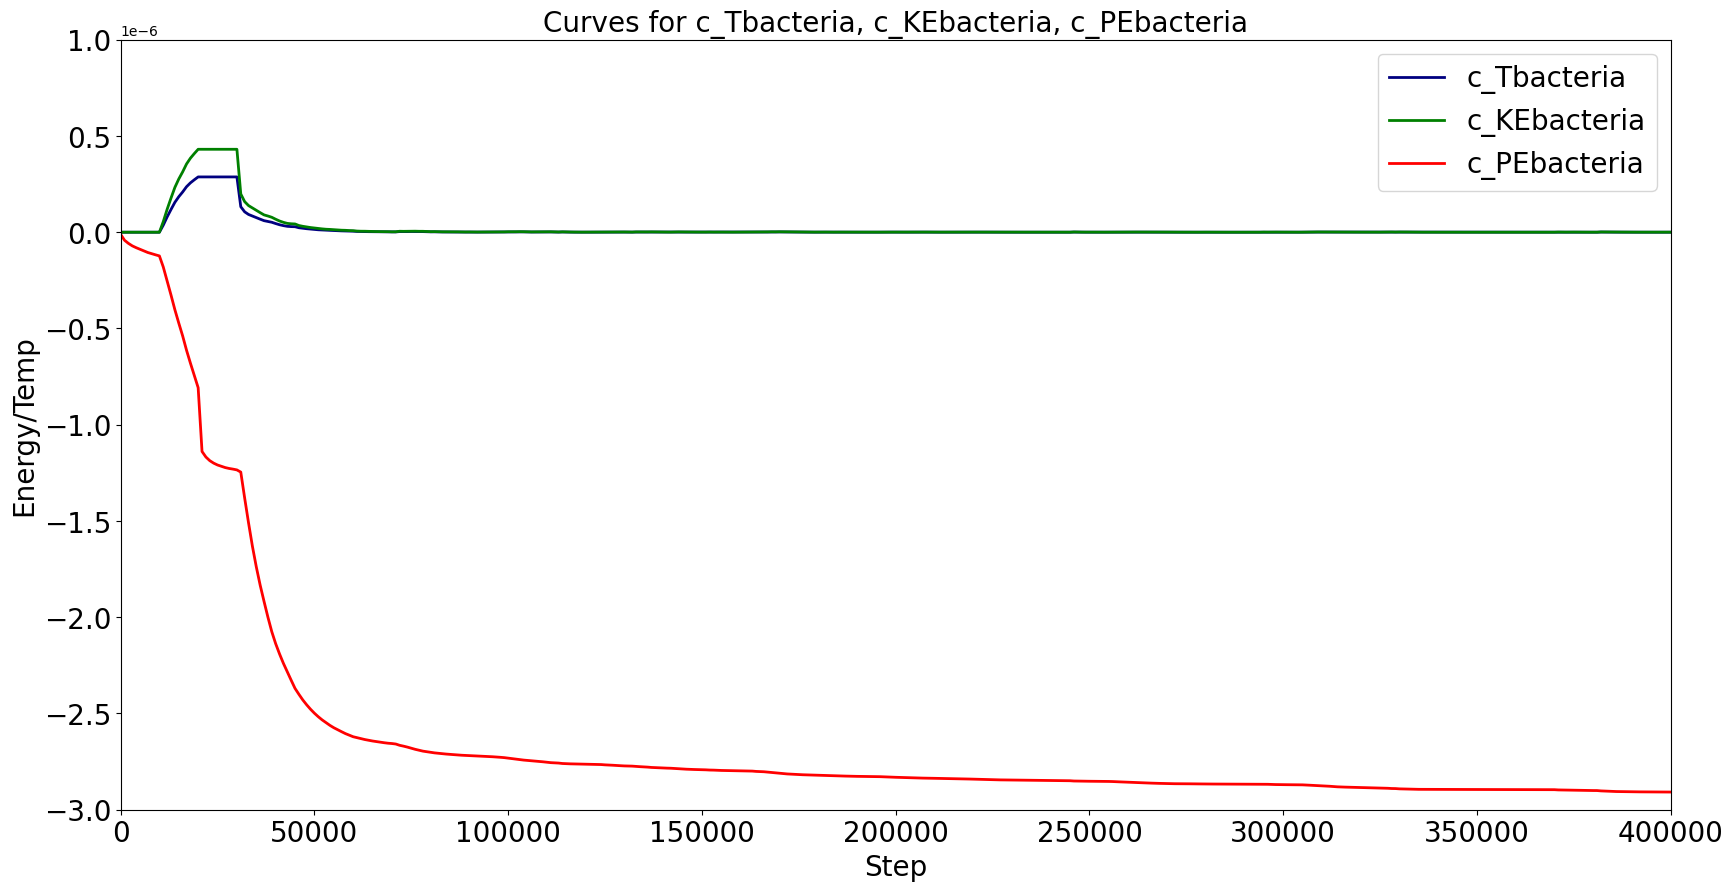

In [39]:
plt.figure(figsize=(20, 10))
# Plot curves for the specified columns
plt.plot(df_lammps_logs_selected['c_Tbacteria'], label='c_Tbacteria', color='navy', linewidth=2)
#plt.plot(df_lammps_logs_selected['c_Tvilli'], label='c_Tvilli', color='cyan')
plt.plot(df_lammps_logs_selected['c_KEbacteria'], label='c_KEbacteria', color='green', linewidth=2)
#plt.plot(df_lammps_logs_selected['c_KEvilli'], label='c_KEvilli', color='lime')
plt.plot(df_lammps_logs_selected['c_PEbacteria'], label='c_PEbacteria', color='red', linewidth=2)
#plt.plot(df_lammps_logs_selected['c_PEvilli'], label='c_PEvilli', color='magenta')

# Add labels and legend
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Step', fontsize=20)
plt.ylabel('Energy/Temp', fontsize=20)
plt.title('Curves for c_Tbacteria, c_KEbacteria, c_PEbacteria', fontsize=20)
plt.ylim((-3e-6, 1e-6))
plt.xlim((-0.2, 0.04 * 10e6))
plt.legend(fontsize=20)
plt.savefig(f"../../data/{experiment_id}/{experiment_type}/bacteria_measurements.png", dpi=300)
# Show the plot
plt.show()